In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  
import torch 
from torch import nn
import pyro
from pyro.distributions import Normal, Beta
from pyro.distributions.torch import Bernoulli
from pyro.infer import Trace_ELBO, SVI
from pyro.infer.predictive import Predictive
from pyro.optim import Adam
from pyro.nn.module import PyroModule, PyroParam, PyroSample
from torch.distributions import constraints

plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
iris_df  = pd.read_csv("/mnt/dl/machine_learning_dataset/iris_dataset/IRIS.csv")

In [3]:
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
iris_df["species"]

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: species, Length: 150, dtype: object

In [5]:
df = iris_df.copy()

In [6]:
df = df[df.species != "Iris-virginica"]
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor
97,6.2,2.9,4.3,1.3,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor


In [7]:
df["species"].value_counts()

species
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64

In [8]:
df["species"] = df["species"].apply(lambda x: {True: 0, False: 1}[x == 'Iris-setosa'])

In [9]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


Text(0.5, 0, 'Sepal Length')

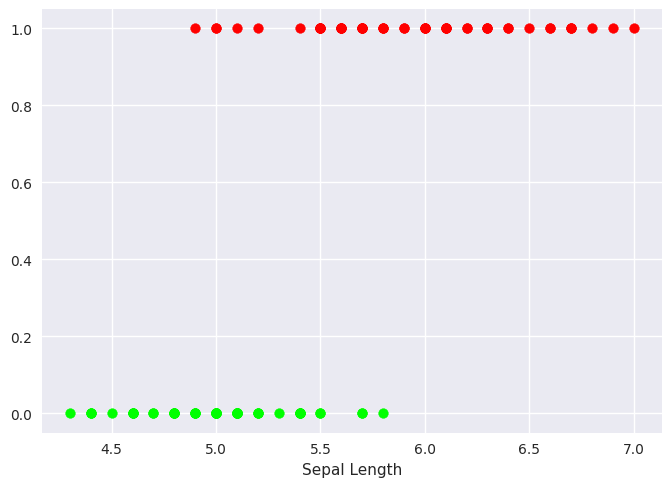

In [10]:
fig, ax = plt.subplots()
versicolor = df[df.species == 1]
setosa = df[df.species == 0]
ax.scatter(versicolor.sepal_length, versicolor.species, c="#F00")
ax.scatter(setosa.sepal_length, setosa.species, c="#0F0")
ax.set_xlabel("Sepal Length")

In [11]:
outliers_length = np.random.uniform(4.0, 4.7, (5, ))
outliers_class = np.ones_like(outliers_length)

In [12]:
Nin = len(df)
df = df[["sepal_length", "species"]]
df["outliers"] = 0
df = pd.concat([df, pd.DataFrame({"sepal_length": outliers_length, "species": outliers_class,
                                  "outliers": 1})], axis=0)
df

/tmp/ipykernel_2435/1843461220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers"] = 0


,sepal_length,species,outliers
0,5.100000,0.0,0
1,4.900000,0.0,0
2,4.700000,0.0,0
3,4.600000,0.0,0
4,5.000000,0.0,0
...,...,...,...
0,4.695315,1.0,1
1,4.345219,1.0,1
2,4.307028,1.0,1
3,4.617720,1.0,1


In [13]:
df = df.reset_index(drop=True)
df

,sepal_length,species,outliers
0,5.100000,0.0,0
1,4.900000,0.0,0
2,4.700000,0.0,0
3,4.600000,0.0,0
4,5.000000,0.0,0
...,...,...,...
100,4.695315,1.0,1
101,4.345219,1.0,1
102,4.307028,1.0,1
103,4.617720,1.0,1


In [14]:
indices = np.arange(0, len(df))
np.random.shuffle(indices)
indices

array([ 50,  11,  41,  36,  18,   5,  20,  56, 103,  13,  32,  97,  29,
        72,  67,  23,  40,  27,   6,  47,  99,  62, 102,  60,  69,   0,
        54,  95,  16,  57, 104,  66,  17,  21,  89,  28,  81,  52,  58,
        35,  42,  94,  30,  46,  34,  86,  83,  68,  19,  63,  85,  88,
        49,  71,  37, 100,  14,  76,  77,  26,  51,  22,  84,  53,  64,
        87,   7,  96,   3,  10,  25,   9,  45,  65,  78,   8,  38,  39,
         4,  82,  12,  98,  15,  75,  59,  61,  70,   1,  73,  48,  31,
        74,   2,  93,  33,  43,  90,  91,  80,  55,  24, 101,  79,  44,
        92])

In [15]:
df = df.iloc[indices]

In [16]:
df

,sepal_length,species,outliers
50,7.000000,1.0,0
11,4.800000,0.0,0
41,4.500000,0.0,0
36,5.500000,0.0,0
18,5.700000,0.0,0
...,...,...,...
24,4.800000,0.0,0
101,4.345219,1.0,1
79,5.700000,1.0,0
44,5.100000,0.0,0


In [17]:
x = df["sepal_length"]
y = df["species"].astype(int)

In [18]:
xc = (x - x.mean()) / np.sqrt(np.var(x) + 1e-9)
yc = y.copy()
xc

50     2.400056
11    -0.954432
41    -1.411862
36     0.112905
18     0.417858
         ...   
24    -0.954432
101   -1.647867
79     0.417858
44    -0.497002
92     0.570335
Name: sepal_length, Length: 105, dtype: float64

In [19]:
xc, yc = torch.from_numpy(xc.values).float(), torch.from_numpy(yc.values).float()

In [20]:
xc, yc

(tensor([ 2.4001, -0.9544, -1.4119,  0.1129,  0.4179, -0.0396, -0.0396,  1.3327,
         -1.2324, -1.7168, -0.3445,  1.1802, -1.1069,  1.3327,  0.5703, -0.4970,
         -0.6495, -0.3445, -1.2594, -1.2594,  0.4179,  0.8753, -1.7061, -0.6495,
          0.2654, -0.4970,  1.6377,  0.4179, -0.0396, -0.8020, -1.1683,  0.2654,
         -0.4970, -0.4970,  0.1129, -0.3445,  0.1129,  2.2476,  1.7901, -0.6495,
         -1.5643,  0.2654, -0.9544, -0.4970, -0.8020,  1.9426,  0.8753,  1.1802,
         -0.4970,  1.0278,  0.8753,  0.2654, -0.6495,  1.0278, -0.8020, -1.1141,
          0.5703,  2.0951,  1.9426, -0.6495,  1.4852, -1.2594, -0.0396,  0.1129,
          0.2654,  1.3327, -0.6495,  0.4179, -1.2594, -0.0396, -0.6495, -0.8020,
         -0.9544,  1.9426,  0.8753, -1.5643, -1.5643, -0.4970, -0.6495,  0.5703,
         -0.9544, -0.4970,  0.4179,  1.7901, -0.3445,  0.7228,  0.7228, -0.8020,
          1.0278, -0.1920, -0.0396,  1.4852, -1.1069, -0.6495,  0.1129, -0.6495,
          0.1129,  1.0278,  

In [21]:
d = pyro.sample("pi", Beta(1.0, 1.0).expand([100]))

In [22]:
d

tensor([0.3432, 0.2559, 0.0097, 0.3637, 0.0891, 0.8770, 0.3049, 0.6585, 0.4348,
        0.2925, 0.1354, 0.7341, 0.1230, 0.2617, 0.2355, 0.5497, 0.6828, 0.2837,
        0.1713, 0.4757, 0.5546, 0.0846, 0.5704, 0.0210, 0.4116, 0.2684, 0.0633,
        0.5161, 0.3320, 0.6198, 0.0822, 0.4482, 0.3905, 0.8059, 0.1502, 0.9073,
        0.4641, 0.4783, 0.6776, 0.4100, 0.8055, 0.2866, 0.5360, 0.3129, 0.2604,
        0.5779, 0.0365, 0.0705, 0.0471, 0.1371, 0.4057, 0.4422, 0.3697, 0.8023,
        0.8134, 0.1834, 0.4924, 0.8906, 0.1897, 0.3405, 0.2327, 0.6509, 0.8941,
        0.8850, 0.8923, 0.8800, 0.1509, 0.5912, 0.3633, 0.8338, 0.8971, 0.3883,
        0.9373, 0.2529, 0.1950, 0.6276, 0.4490, 0.4371, 0.8643, 0.0976, 0.3351,
        0.5806, 0.4761, 0.3736, 0.0882, 0.1646, 0.9013, 0.8106, 0.9342, 0.5245,
        0.2560, 0.7398, 0.1550, 0.3181, 0.9744, 0.5872, 0.3120, 0.8570, 0.9837,
        0.6724])

In [23]:
Beta(0.5, 0.5).log_prob(d).exp()

tensor([0.6704, 0.7294, 3.2467, 0.6617, 1.1174, 0.9691, 0.6914, 0.6712, 0.6421,
        0.6997, 0.9302, 0.7205, 0.9690, 0.7241, 0.7502, 0.6398, 0.6840, 0.7061,
        0.8449, 0.6374, 0.6404, 1.1436, 0.6430, 2.2201, 0.6468, 0.7184, 1.3076,
        0.6369, 0.6759, 0.6557, 1.1592, 0.6401, 0.6524, 0.8049, 0.8910, 1.0975,
        0.6383, 0.6372, 0.6811, 0.6472, 0.8042, 0.7040, 0.6383, 0.6865, 0.7253,
        0.6445, 1.6965, 1.2431, 1.5030, 0.9254, 0.6483, 0.6409, 0.6594, 0.7993,
        0.8170, 0.8225, 0.6367, 1.0198, 0.8118, 0.6717, 0.7533, 0.6677, 1.0346,
        0.9978, 1.0267, 0.9795, 0.8893, 0.6475, 0.6618, 0.8550, 1.0477, 0.6531,
        1.3127, 0.7322, 0.8033, 0.6584, 0.6400, 0.6417, 0.9294, 1.0725, 0.6743,
        0.6451, 0.6373, 0.6580, 1.1226, 0.8584, 1.0675, 0.8123, 1.2837, 0.6374,
        0.7294, 0.7255, 0.8795, 0.6834, 2.0164, 0.6465, 0.6870, 0.9092, 2.5149,
        0.6782])

In [47]:
class LogisticRegression():
    
    def model(self, x, y=None):
        
        with pyro.plate("data", len(x)):
            π_dist = Beta(1.0, 1.0)
            π = pyro.sample("π", π_dist)
            weights = pyro.sample("w", Normal(0, 1.))
            bias = pyro.sample("b", Normal(0, 1.))
            lin_reg = torch.sigmoid(weights * x + bias)
                        
            p = π * 0.5 + (1 - π) * lin_reg
            s = pyro.sample("s", Bernoulli(p,), obs=y)
            return s

    def guide(self, x, y=None):
        weights_loc = pyro.param("weights_loc", lambda: torch.randn(1))
        weights_scale = pyro.param("weights_scale", lambda: torch.ones(1), constraint=constraints.positive)
        
        bias_loc = pyro.param("bias_loc", lambda: torch.randn(1))
        bias_scale = pyro.param("bias_scale", lambda: torch.ones(1), constraint=constraints.positive)
        with pyro.plate("data", len(x)):
            weights = pyro.sample("w", Normal(weights_loc, weights_scale))
            bias =  pyro.sample("b", Normal(bias_loc, bias_scale))

In [81]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
torch.manual_seed(0)

m = LogisticRegression()
svi = SVI(model=m.model, guide=m.guide, 
          optim=pyro.optim.Adam(dict(lr=1e-3)), loss=Trace_ELBO())

losses = []
for i in range(2000):
    loss = svi.step(xc, yc) 
    losses.append(loss / len(xc))
    

for name, param in pyro.get_param_store().items():
    print(name, param)
    

/env_nlp/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'π'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


weights_loc tensor([0.2647], requires_grad=True)
weights_scale tensor([0.9826], grad_fn=<AddBackward0>)
bias_loc tensor([0.0183], requires_grad=True)
bias_scale tensor([0.9798], grad_fn=<AddBackward0>)


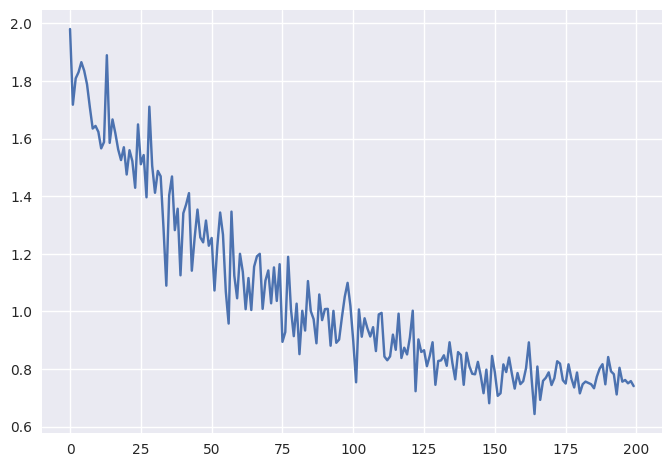

In [82]:
plt.plot(losses[::10])

In [83]:
for name, param in pyro.get_param_store().items():
    print(name, param)

weights_loc tensor([0.2647], requires_grad=True)
weights_scale tensor([0.9826], grad_fn=<AddBackward0>)
bias_loc tensor([0.0183], requires_grad=True)
bias_scale tensor([0.9798], grad_fn=<AddBackward0>)


In [84]:
pr = Predictive(m.model, num_samples=1)

In [85]:
samples = pr.get_samples(xc)

In [86]:
samples

{'π': tensor([[0.2385, 0.0335, 0.7734, 0.9944, 0.2944, 0.5632, 0.5395, 0.6566, 0.6166,
          0.6590, 0.4878, 0.6024, 0.9912, 0.4868, 0.7165, 0.9554, 0.5675, 0.4552,
          0.2192, 0.5008, 0.1011, 0.3909, 0.8242, 0.1017, 0.1202, 0.3635, 0.8688,
          0.0120, 0.5216, 0.0541, 0.4237, 0.4956, 0.0807, 0.3515, 0.4917, 0.2899,
          0.3189, 0.6637, 0.8944, 0.2765, 0.6086, 0.3145, 0.9330, 0.1357, 0.0069,
          0.6564, 0.1923, 0.4514, 0.0054, 0.9984, 0.5643, 0.6206, 0.9907, 0.5861,
          0.0044, 0.2643, 0.5442, 0.4612, 0.5980, 0.7322, 0.4870, 0.5166, 0.0625,
          0.6406, 0.4097, 0.7136, 0.6086, 0.8371, 0.5159, 0.6827, 0.9381, 0.1995,
          0.3560, 0.7457, 0.7504, 0.8421, 0.5831, 0.6609, 0.9836, 0.6441, 0.0167,
          0.0503, 0.6261, 0.6894, 0.2273, 0.9551, 0.9123, 0.6861, 0.6002, 0.1402,
          0.0026, 0.0719, 0.3295, 0.6099, 0.7854, 0.8030, 0.2512, 0.8972, 0.5826,
          0.5581, 0.0485, 0.0444, 0.5340, 0.4929, 0.5087]]),
 'w': tensor([[ 8.4212e-01, -5.2

In [87]:
yc

tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.])

In [88]:
(samples["s"] == yc).sum() / len(xc)

tensor(0.5714)

In [89]:
x[indices]

50     7.000000
11     4.800000
41     4.500000
36     5.500000
18     5.700000
         ...   
24     4.800000
101    4.345219
79     5.700000
44     5.100000
92     5.800000
Name: sepal_length, Length: 105, dtype: float64

{'weights_loc': tensor([0.2647], requires_grad=True),
 'weights_scale': tensor([0.9826], grad_fn=<AddBackward0>),
 'bias_loc': tensor([0.0183], requires_grad=True),
 'bias_scale': tensor([0.9798], grad_fn=<AddBackward0>)}

In [94]:
torch.aminmax(torch.tensor(x))

torch.return_types.aminmax(
min=tensor(4.3000, dtype=torch.float64),
max=tensor(7., dtype=torch.float64))

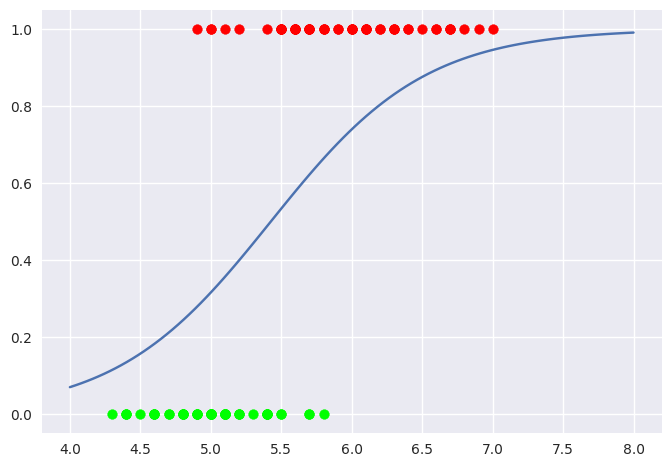

In [113]:
fig, ax = plt.subplots()
params = dict(pyro.get_param_store())
weights_loc = params["weights_loc"]
bias_loc = params["bias_loc"]
weights_scale = params["weights_scale"]
bias_scale = params["bias_scale"]

points = torch.linspace(4, 8., 100)
p = (points - x.mean()) / np.sqrt(x.var() + 1e-9)
# z = torch.sigmoid(weights_loc * p ).clone().detach().cpu()
z = torch.sigmoid(Normal(weights_loc, weights_scale).sample() * p ).clone().detach().cpu()

ax.plot(points, z)
ax.scatter(versicolor.sepal_length, versicolor.species, c="#F00")
ax.scatter(setosa.sepal_length, setosa.species, c="#0F0")

In [101]:
x.mean()

5.425952648889387